## Coding Assessment

### Jacob Blevins

In [23]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

# Data
sales = pd.read_csv('sales.csv')
leads = pd.read_csv('leads.csv')

/home/jblevins32/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### 1. Currency Conversion

In [24]:
# Mask buyer Y and sale time between 8AM and 9AM
sales["sale_timestamp"] = pd.to_datetime(sales["sale_timestamp"], errors="coerce")
mask = ((sales["buyer_name"] == "Y") & (sales["sale_timestamp"].dt.hour == 8))

# Update masked sales to USD
# Assumption: 1 CAD = 0.74 USD
sales.loc[mask, "revenue"] = sales.loc[mask, "revenue"] * 0.74

# Save new sales data
sales.to_csv('sales_fixed.csv', index=False)

### 2. Basic Performance Metrics

In [32]:
def metrics(category_df, file_name):
    '''
    Helper Function to extract info from a pandas df:

        - Conversion Rate (CVR): #converted / #total_sales
        - Total Revenue (in US dollar)
        - Revenue per Sale: total_revenue / #total_sales

    Inputs:
        - category_df: pandas DataFrame grouped by a specific category
        - file_name: string name for output CSV file (without .csv extension)

    Outputs:
        - results_df: pandas DataFrame with calculated metrics for each item in category

    Assumptions:
        -
        -
        -
    '''

    # Initialize metrics dictionary
    category_metrics = {}

    # Calculate metrics for each item in category
    for item, item_data in category_df:
        
        # Conversion Rate
        num_converted = len(item_data.loc[item_data["converted"] == "Yes"])
        num_sales = len(item_data)
        conversion_rate = num_converted / num_sales if num_sales > 0 else 0

        # Total Revenue
        total_revenue = item_data["revenue"].sum()

        # Revenue per Sale
        revenue_per_sale = total_revenue / num_sales if num_sales > 0 else 0

        # Store results
        category_metrics[item] = {
            "conversion_rate": conversion_rate,
            "total_revenue": total_revenue,
            "revenue_per_sale": revenue_per_sale
        }

    # Build and export table
    results_df = pd.DataFrame.from_dict(category_metrics, orient='index')
    results_df = results_df.reset_index().rename(columns={"index": "item_name"})
    results_df.to_csv(f'{file_name}.csv', index=False)

    return results_df

In [ ]:
# Extract buyer metrics
buyer_sales = sales.groupby("buyer_name")

buyer_metrics = metrics(buyer_sales, "buyer_metrics")

print(buyer_metrics)

  item_name  conversion_rate  total_revenue  revenue_per_sale
0         X         0.238095       8297.640         56.446531
1         Y         0.032258       1357.882         43.802645


### 3. A/B Test Analysis

  item_name  conversion_rate  total_revenue  revenue_per_sale
0         A         0.200000       4072.681         54.302413
1         B         0.203883       5582.841         54.202340
Chi-squared Test p-value: 1.0
The difference in conversion rates between groups is not statistically significant.


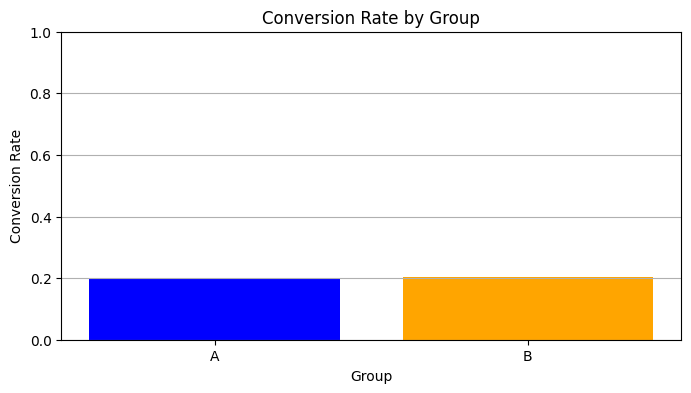

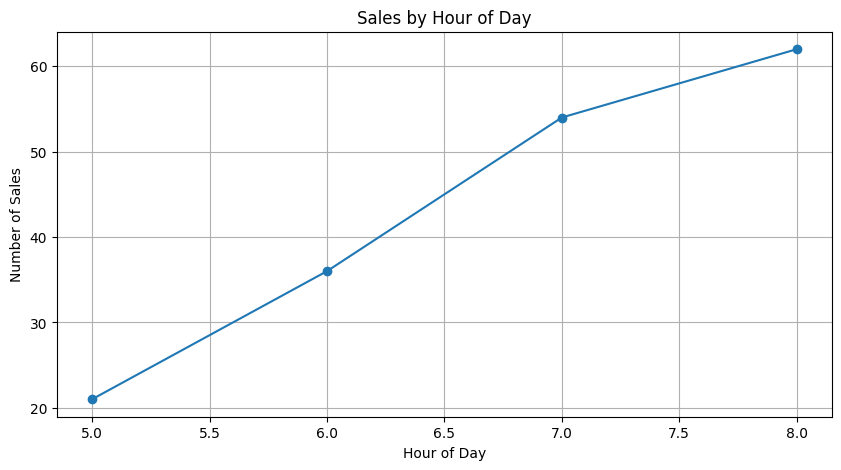

In [49]:
# Extract group metrics
group_sales = sales.groupby("ab_group")

group_metrics = metrics(group_sales, "group_metrics")

print(group_metrics)

# Plot results
plt.figure(figsize=(8, 4))
plt.bar(group_metrics["item_name"], group_metrics["conversion_rate"], color=['blue', 'orange'])
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Group')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.savefig('ab_group_conversion_rate.png')

# Test statistical significance of conversion rates between groups
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(sales['ab_group'], sales['converted'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-squared Test p-value: {p}')
if p < 0.05:
    print('The difference in conversion rates between groups is statistically significant.')
else:
    print('The difference in conversion rates between groups is not statistically significant.')

# Sales by hour
sales['hour'] = sales['sale_timestamp'].dt.hour
hourly_sales = sales.groupby('hour').size()
plt.figure(figsize=(10, 5))
plt.plot(hourly_sales.index, hourly_sales.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sales')
plt.title('Sales by Hour of Day')
plt.grid()
plt.savefig('sales_by_hour.png')

### 4. Lead-to-Sale Join

In [79]:
# Merge sales and leads on lead_id, removing those without a sale record
merged_data = pd.merge(leads, sales, on='lead_id', how='left')
merged_data.to_csv(f'merged_data.csv', index=False)

### 5. Email Campaign Frequency

In [81]:
# How many different campaign IDs were observed with this email before the lead came in?

# For each lead, how many campaign IDs had this same email before the lead came in

# merged_data["sale_timestamp"] = pd.to_datetime(
#     merged_data["sale_timestamp"], errors="coerce"
# )

# merged_data["lead_timestamp"] = pd.to_datetime(
#     merged_data["lead_timestamp"], errors="coerce"
# )

# Create all combinations where the email matches
joined = merged_data.merge(merged_data, on="email_address", suffixes=("_lead", "_campaign"))

# Keep only rows where the sale happened before the lead timestamp
joined = joined[joined["sale_timestamp_campaign"] < joined["lead_timestamp_lead"]]

result = (
    joined.groupby(["lead_id_lead", "email_address"])["campaign_id_campaign"]
    .nunique()
    .reset_index(name="duplicate_campaign_count")
    .sort_values("duplicate_campaign_count", ascending=False)
    .reset_index(drop=True)
)

display(result)

summary = (
    result["duplicate_campaign_count"]
    .value_counts()
    .sort_index()
    .reset_index()
)

summary.columns = ["num_prior_campaigns", "num_sales"]

display(summary)

plt.figure()
plt.bar(summary["num_prior_campaigns"], summary["num_sales"])
plt.xlabel("Number of Different Campaign IDs Before Sale")
plt.ylabel("Number of Sales")
plt.title("Prior Campaign Exposure Before Lead Sale")
plt.show()
   

KeyboardInterrupt: 

### 6. Correlation Analysis (March 7 Leads Only)